In [16]:
import numpy as np

# two d=3 qudits

In [17]:
n_qubits = 2
d = 3

### Generate "unkown" state you want to learn

In [18]:
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

psi = random_complex_vector(d).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4]:
smaller_bases = True

if smaller_bases is True:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, i]
else:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [5]:
# 2 qubits
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
two_qubit_measurement_operators = []
for qubit_1_op in measurement_operators:
    for qubit_2_op in measurement_operators:
        two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [6]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [7]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [8]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [9]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [10]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [11]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [12]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [13]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [14]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [15]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9996717884760534


### Plot Density Matrices

In [16]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

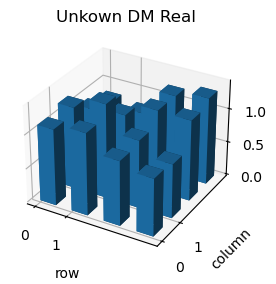

[[1.12336148 1.20881447 0.95264226 0.84696659]
 [1.20881447 1.38974343 1.00184512 0.7992081 ]
 [0.95264226 1.00184512 1.20353974 1.19040546]
 [0.84696659 0.7992081  1.19040546 1.28335535]]


In [18]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

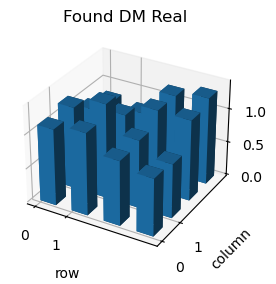

[[1.12342291 1.20873763 0.95263426 0.84695718]
 [1.20873763 1.38968922 1.00192899 0.79931572]
 [0.95263426 1.00192899 1.20353856 1.19037121]
 [0.84695718 0.79931572 1.19037121 1.28334931]]


In [19]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

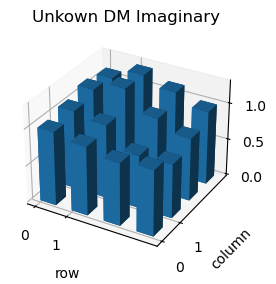

[[1.         0.93309826 0.84878423 0.89259464]
 [1.06690174 1.         0.71835329 0.73520102]
 [1.15121577 1.28164671 1.         0.85364483]
 [1.10740536 1.26479898 1.14635517 1.        ]]


In [20]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

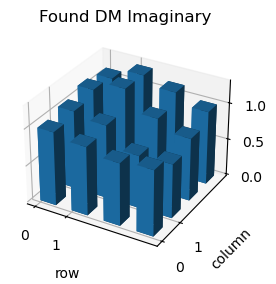

[[1.         0.93311669 0.84890415 0.89279081]
 [1.06688331 1.         0.7184468  0.73537112]
 [1.15109585 1.2815532  1.         0.85366079]
 [1.10720919 1.26462888 1.14633921 1.        ]]


In [21]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [22]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [23]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[-0.3103536 -0.1644449j ]
 [-0.43615457-0.44666835j]
 [ 0.32071846-0.31730018j]
 [ 0.52817729-0.06621253j]]
prob_0 [0.12336148]
prob_1 [0.38974343]


#### original psi from density matrix, testing that it matches psi

In [24]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.35122853+0.j          0.59452594+0.19047922j -0.13483453+0.43053384j
 -0.43570894+0.30579907j]
prob_0 0.12336148239179756
prob_1 0.38974342667117934


#### statevector from reconstructed dm

In [25]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [-0.35120976+0.j         -0.59445074-0.1906963j   0.13494065-0.43053258j
  0.43584197-0.30559686j]
prob_0 0.12334829356275606
prob_1 0.3897367595587447


### State vector fidelity

In [26]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [27]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999999781603238